# MLP in JAX

This is an exploration of the basic concepts of JAX by building a Multi-Layer Perceptron. This notebook follows Robert Lange's [tutorial](https://roberttlange.github.io/posts/2020/03/blog-post-10/).

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

/home/elaanaj/miniconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
# Generate a random matrix
x = random.uniform(key, (1000, 1000))
# Compare running times of 3 different matrix multiplications
%time y = onp.dot(x, x)
%time y = np.dot(x, x)
%time y = np.dot(x, x).block_until_ready()

CPU times: user 98.3 ms, sys: 57.4 ms, total: 156 ms
Wall time: 27.7 ms
CPU times: user 15.3 ms, sys: 34.7 ms, total: 49.9 ms
Wall time: 7.36 ms
CPU times: user 190 ms, sys: 187 ms, total: 377 ms
Wall time: 54.9 ms


## A Few Basic Concepts & Conventions - jit, grad & vmap

Before diving into the nitty-gritty details of training some neural nets in JAX, let's have a look at the basic ingredients that make things work. **jit** (just-in-time compilation) lies at the core of speeding up your code. In practice we simply wrap (`jit()`) or decorate (`@jit`) the function of interest.

In [5]:
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)

The first time we call the jitted function it will be compiled and it may take a little longer. But afterwards, the machine code is ready to shine.

In [6]:
%time out = ReLU(x).block_until_ready()
# Call jitted version to compile for evaluation time!
%time jit_ReLU(x).block_until_ready()
%time out = jit_ReLU(x).block_until_ready()

CPU times: user 40.5 ms, sys: 0 ns, total: 40.5 ms
Wall time: 38.7 ms
CPU times: user 18.4 ms, sys: 0 ns, total: 18.4 ms
Wall time: 16.9 ms
CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 605 µs


The next tool in our kit is **grad**. It is the autodiff backbone of JAX and is inherited from the Autograd package. By wrapping your function with grad and evaluating it, you get the gradient evaluation returned. Let's have a look at how this would work with our ReLU activation function:

In [7]:
def FiniteDiffGrad(x):
    """ Compute the finite difference derivative approx for the ReLU"""
    return np.array((ReLU(x + 1e-3) - ReLU(x - 1e-3)) / (2 * 1e-3))

# Compare the Jax gradient with a finite difference approximation
print("Jax Grad: ", jit(grad(jit(ReLU)))(2.))
print("FD Gradient:", FiniteDiffGrad(2.))

Jax Grad:  1.0
FD Gradient: 0.99998707


In [8]:
batch_dim = 32
feature_dim = 100
hidden_dim = 512

# Generate a batch of vectors to process
X = random.normal(key, (batch_dim, feature_dim))

# Generate Gaussian weights and biases
params = [random.normal(key, (hidden_dim, feature_dim)),
          random.normal(key, (hidden_dim, ))] 

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(np.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

out = np.stack([relu_layer(params, X[i, :]) for i in range(X.shape[0])])
out = batch_version_relu_layer(params, X)
out = vmap_relu_layer(params, X)

## Training a MNIST Multilayer Perceptron in JAX

In [11]:
!conda install -c pytorch torchvision -y

Solving environment: done

## Package Plan ##

  environment location: /home/elaanaj/miniconda3

  added / updated specs:
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    torchvision-0.8.2          |       py37_cu110        18.0 MB  pytorch
    ------------------------------------------------------------
                                           Total:        18.0 MB

The following NEW packages will be INSTALLED:

  lcms2              pkgs/main/linux-64::lcms2-2.11-h396b838_0
  olefile            pkgs/main/linux-64::olefile-0.46-py37_0
  pillow             pkgs/main/linux-64::pillow-8.1.0-py37he98fc37_0
  torchvision        pytorch/linux-64::torchvision-0.8.2-py37_cu110

The following packages will be UPDATED:

  freetype                                2.10.2-h5ab3b9f_0 --> 2.10.4-h5ab3b9f_0



torchvision-0.8.2    | 18.0 MB   | ##################################### |

In [17]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

import torch
from torchvision import datasets, transforms

import time
from utils import jax_utils as helpers

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!






/home/elaanaj/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


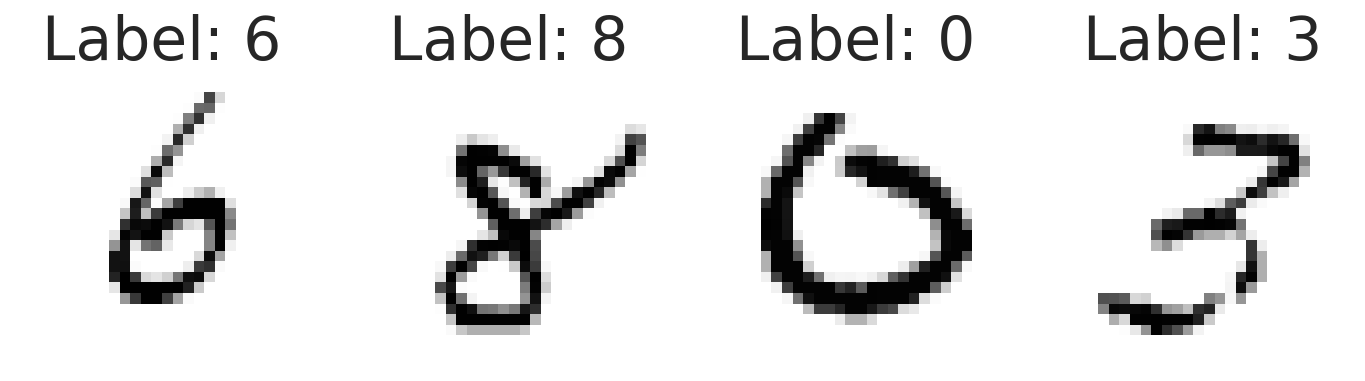

In [18]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)


helpers.plot_mnist_examples(train_loader)

In [19]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [20]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array
    
    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)
    
    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [21]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)
  
def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)
    
        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(batch_forward(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

In [22]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10

In [ ]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []
    
    # Get the initial set of parameters 
    params = get_params(opt_state)
    
    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)
    
    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    
    return train_loss, log_acc_train, log_acc_test


train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")

# Plot the loss curve over time
helpers.plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST MLP Performance")

Epoch 1 | T: 10.73 | Train A: 0.975 | Test A: 0.970
Epoch 2 | T: 10.67 | Train A: 0.984 | Test A: 0.977
Epoch 3 | T: 10.74 | Train A: 0.990 | Test A: 0.977
Epoch 4 | T: 10.85 | Train A: 0.991 | Test A: 0.978
Epoch 5 | T: 10.89 | Train A: 0.995 | Test A: 0.980
Epoch 6 | T: 10.78 | Train A: 0.995 | Test A: 0.980
Epoch 7 | T: 10.69 | Train A: 0.997 | Test A: 0.979
Epoch 8 | T: 10.78 | Train A: 0.998 | Test A: 0.983
Epoch 9 | T: 10.75 | Train A: 0.999 | Test A: 0.983
